In [1]:
from datetime import datetime
from tqdm import trange
from typing import List, Tuple, Dict
from pprint import pprint
from copy import deepcopy

import torch
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bayes_opt import BayesianOptimization, acquisition
import random

# Set seeds for reproducibility
torch.manual_seed(1)
np.random.seed(1)
random.seed(1)

# Ensure deterministic behavior in PyTorch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/home/bruno/anaconda3/envs/fiap/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


device(type='cuda')

In [2]:
NDVI_PATH = "../data/PROCESSED/ndvi.csv"
PROD_PATH = "../data/PROCESSED/manhuacu.csv"

In [3]:
# MLP Hyperparameters
MLP_WINDOW_SIZE = 10
MLP_BATCH_SIZE = 8
MLP_BASE_HIDDEN_SIZE = 64
MLP_EPOCHS = 300
MLP_LEARNING_RATE = 1e-3
MLP_DROPOUT = 0.2

# Best MLP Hyperparameters
# MLP_WINDOW_SIZE = 10
# MLP_BATCH_SIZE = 4
# MLP_BASE_HIDDEN_SIZE = 32
# MLP_EPOCHS = 300
# MLP_LEARNING_RATE = 2e-3

# Validation Loss: 0.1911

# LSTM Hyperparameters
LSTM_WINDOW_SIZE = 10
LSTM_HIDDEN_SIZE = 32
LSTM_NUM_LAYERS = 2
LSTM_DROPOUT = 0.2
LSTM_EPOCHS = 200
LSTM_BATCH_SIZE = 4
LSTM_LEARNING_RATE = 1e-4

# Best LSTM Hyperparameters So Far
# LSTM_WINDOW_SIZE = 20
# LSTM_HIDDEN_SIZE = 32
# LSTM_NUM_LAYERS = 2
# LSTM_DROPOUT = 0.2
# LSTM_EPOCHS = 1000
# LSTM_BATCH_SIZE = 16
# LSTM_LEARNING_RATE = 5e-5

# Validation Loss: 0.2122

# Bayesian Optimization Hyperparameters
INIT_POINTS = 8
N_ITER = 16


# Computation
LSTM_DROPOUT = LSTM_DROPOUT if LSTM_NUM_LAYERS > 1 else 0

In [4]:
def get_day_of_year_index(date: datetime):
    """Convert date to day of year."""
    return datetime(date.year, date.month, date.day).timetuple().tm_yday - 1


def get_sin_cos(x: float):
    """Convert x to sin and cos."""
    rad = 2 * np.pi * x
    return (np.sin(rad), np.cos(rad))


def encode_date(date: datetime):
    is_leap_year = 1 if date.year % 4 == 0 else 0
    total_year_days = 366 if is_leap_year else 365
    day_index = get_day_of_year_index(date)
    return get_sin_cos(day_index / total_year_days)


# Test
print("Encoding date 2020-01-01")
print(encode_date(datetime(2020, 1, 1)))  # (0.0, 1.0)
print("\n")
print("Encoding date 2020-06-01")
print(encode_date(datetime(2020, 6, 1)))  # (0.5, 0.0)
print("\n")
print("Encoding date 2020-12-31")
print(encode_date(datetime(2020, 12, 31)))  # (0.9999999999999999, 1.0)
print("\n")

Encoding date 2020-01-01
(0.0, 1.0)


Encoding date 2020-06-01
(0.5074150932938454, -0.8617017599480682)


Encoding date 2020-12-31
(-0.017166329754707492, 0.9998526477050269)




## 1. Carregar e Pré-processar Dados

### 1.1. Carregar e pre-processar os Dados

In [5]:
NDVI = pd.read_csv(NDVI_PATH)
NDVI

,Data,NDVI,Year
0,2000-02-18,0.482058,2000
1,2000-03-05,0.476160,2000
2,2000-03-21,0.483806,2000
3,2000-04-06,0.495976,2000
4,2000-04-22,0.468606,2000
...,...,...,...
574,2025-02-02,0.403857,2025
575,2025-02-18,0.366805,2025
576,2025-03-06,0.407189,2025
577,2025-03-22,0.383104,2025


In [6]:
NDVI["N_Observations"] = NDVI.groupby("Year")["Data"].transform("count")

NDVI[["Date_sin", "Date_cos"]] = NDVI["Data"].apply(
    lambda x: pd.Series(encode_date(datetime.strptime(x, "%Y-%m-%d")))
)

# Assert order by Data (ascending)
NDVI = NDVI.sort_values(by="Data", ascending=True)

NDVI = NDVI[(NDVI["Year"] >= 2000) & (NDVI["Year"] <= 2023)]

NDVI

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos
0,2000-02-18,0.482058,2000,20,0.733885,0.679273
1,2000-03-05,0.476160,2000,20,0.890617,0.454755
2,2000-03-21,0.483806,2000,20,0.980575,0.196143
3,2000-04-06,0.495976,2000,20,0.997018,-0.077175
4,2000-04-22,0.468606,2000,20,0.938710,-0.344707
...,...,...,...,...,...,...
544,2023-10-16,0.357962,2023,23,-0.970064,0.242850
545,2023-11-01,0.363316,2023,23,-0.867456,0.497513
546,2023-11-17,0.354856,2023,23,-0.699458,0.714673
547,2023-12-03,0.364375,2023,23,-0.478734,0.877960


In [7]:
PROD = pd.read_csv(PROD_PATH)
PROD = PROD[(PROD["Year"] >= 2000) & (PROD["Year"] <= 2023)]
# max_productivity = PROD["Productivity (kg/ha)"].max()
# PROD["Normalized_productivity"] = PROD["Productivity (kg/ha)"] / max_productivity
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha)
26,2000,17424000,13200,1320.000000
27,2001,17424000,13200,1320.000000
28,2002,26325000,17550,1500.000000
29,2003,13533000,17350,780.000000
30,2004,16560000,17250,960.000000
31,2005,16065000,17850,900.000000
32,2006,16065000,17850,900.000000
33,2007,16065000,17850,900.000000
34,2008,23958000,18150,1320.000000
35,2009,20235000,17750,1140.000000


### 1.2. Visualizar os dados

<Axes: title={'center': 'NDVI over time'}, xlabel='Data'>

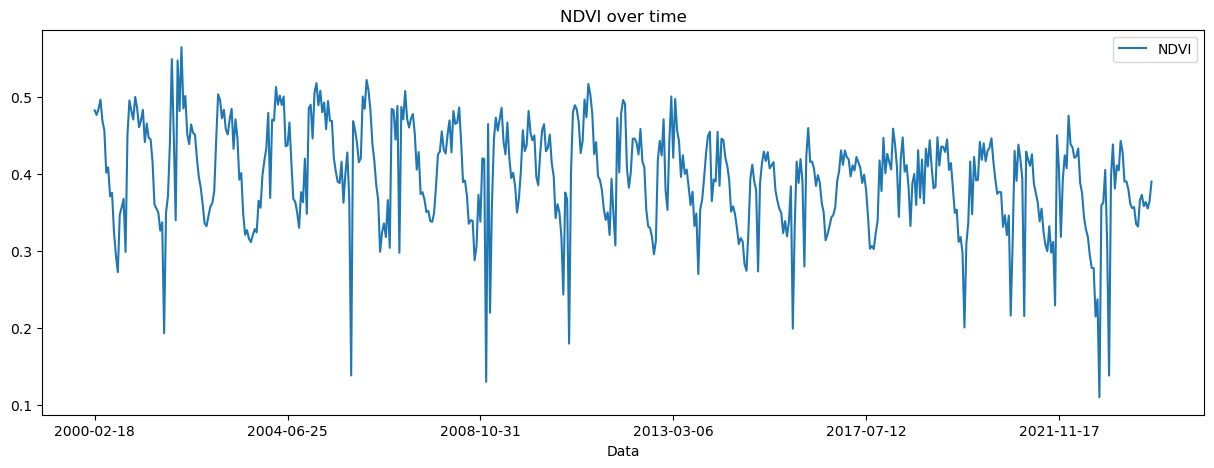

In [8]:
NDVI.plot(x="Data", y="NDVI", title="NDVI over time", figsize=(15, 5))

### 2.2. Preparar Datasets

#### 2.1.1. Normalização

In [9]:
from sklearn.preprocessing import StandardScaler

# Normalizer dados NDVI
NDVI["Year_norm"] = NDVI["Year"].copy()

ndvi_scaler = StandardScaler().fit(NDVI[["NDVI", "Year"]].values)
NDVI[["NDVI_norm", "Year_norm"]] = ndvi_scaler.transform(NDVI[["NDVI", "Year"]].values)

NDVI

,Data,NDVI,Year,N_Observations,Date_sin,Date_cos,Year_norm,NDVI_norm
0,2000-02-18,0.482058,2000,20,0.733885,0.679273,-1.678564,1.290739
1,2000-03-05,0.476160,2000,20,0.890617,0.454755,-1.678564,1.201752
2,2000-03-21,0.483806,2000,20,0.980575,0.196143,-1.678564,1.317123
3,2000-04-06,0.495976,2000,20,0.997018,-0.077175,-1.678564,1.500766
4,2000-04-22,0.468606,2000,20,0.938710,-0.344707,-1.678564,1.087770
...,...,...,...,...,...,...,...,...
544,2023-10-16,0.357962,2023,23,-0.970064,0.242850,1.660319,-0.581774
545,2023-11-01,0.363316,2023,23,-0.867456,0.497513,1.660319,-0.500980
546,2023-11-17,0.354856,2023,23,-0.699458,0.714673,1.660319,-0.628630
547,2023-12-03,0.364375,2023,23,-0.478734,0.877960,1.660319,-0.485003


In [10]:
# Normalizar produtividade
PROD["Year_norm"] = NDVI["Year"].copy()

prod_scaler = StandardScaler().fit(PROD[["Productivity (kg/ha)", "Year"]].values)
PROD[["Productivity_norm", "Year_norm"]] = prod_scaler.transform(
    PROD[["Productivity (kg/ha)", "Year"]].values
)
PROD

,Year,Production (kg),Area (ha),Productivity (kg/ha),Year_norm,Productivity_norm
26,2000,17424000,13200,1320.000000,-1.661325,0.425926
27,2001,17424000,13200,1320.000000,-1.516862,0.425926
28,2002,26325000,17550,1500.000000,-1.372399,1.171894
29,2003,13533000,17350,780.000000,-1.227936,-1.811979
30,2004,16560000,17250,960.000000,-1.083473,-1.066011
31,2005,16065000,17850,900.000000,-0.939010,-1.314667
32,2006,16065000,17850,900.000000,-0.794547,-1.314667
33,2007,16065000,17850,900.000000,-0.650084,-1.314667
34,2008,23958000,18150,1320.000000,-0.505621,0.425926
35,2009,20235000,17750,1140.000000,-0.361158,-0.320043


In [11]:
class DatasetYearOfLast(torch.utils.data.Dataset):
    def __init__(self, ndvi_df, prod_df, window_size=LSTM_WINDOW_SIZE):
        self.ndvi_df = ndvi_df.copy().reset_index(drop=True)
        self.window_size = window_size
        self.prod_df = prod_df

        # Prepare windows grouped by year
        self.samples = []
        self.available_years = ndvi_df["Year"].unique().tolist()

        for idx, row in self.ndvi_df.iterrows():
            window = ndvi_df.iloc[idx : idx + window_size]

            if len(window) < window_size:
                break

            last_of_window = self.ndvi_df.iloc[idx + window_size - 1]

            if last_of_window["Year"] == row["Year"] or (
                last_of_window["Year"] == row["Year"] + 1
                and row["Year"] + 1 in self.available_years
            ):
                self.samples.append((window, last_of_window["Year"]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        window, year = self.samples[idx]
        ndvi = window[["NDVI", "Date_sin", "Date_cos", "Year_norm"]].values

        prod = self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0]

        return torch.tensor(ndvi, dtype=torch.float32), torch.tensor(
            prod, dtype=torch.float32
        )

    def get_last_window_of_year(self, year) -> np.ndarray:
        """
        Retorna a última janela do ano
        """

        ndvi = self.ndvi_df[self.ndvi_df["Year"] == year]
        if ndvi.empty:
            raise ValueError(f"Year {year} not found in dataset")
        if len(ndvi) < self.window_size:
            raise ValueError(
                f"Year {year} has only {len(ndvi)} observations, less than window size {self.window_size}"
            )
        return (
            ndvi.iloc[-self.window_size :][
                ["NDVI", "Date_sin", "Date_cos", "Year_norm"]
            ].values,
            self.prod_df[self.prod_df["Year"] == year]["Productivity_norm"].values[0],
        )


years_validation = [2004, 2010, 2016, 2022]
years_test = [2005, 2011, 2017, 2023]
years_train = PROD[~PROD["Year"].isin(years_validation + years_test)]["Year"].unique()


# Datasets better
dataset_train = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, MLP_WINDOW_SIZE
)
dataset_validation = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, MLP_WINDOW_SIZE
)
mlp_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, MLP_WINDOW_SIZE
)

lstm_train_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_train)], PROD, LSTM_WINDOW_SIZE
)
lstm_validation_dataset_year_of_last = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_validation)], PROD, LSTM_WINDOW_SIZE
)
lstm_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, LSTM_WINDOW_SIZE
)


print(dataset_validation[0])
print("\n")
print(dataset_validation.get_last_window_of_year(2004))

(tensor([[ 0.4331,  0.0000,  1.0000, -1.0979],
        [ 0.4789,  0.2712,  0.9625, -1.0979],
        [ 0.3686,  0.5221,  0.8529, -1.0979],
        [ 0.4699,  0.7339,  0.6793, -1.0979],
        [ 0.4688,  0.8906,  0.4548, -1.0979],
        [ 0.5123,  0.9806,  0.1961, -1.0979],
        [ 0.4895,  0.9970, -0.0772, -1.0979],
        [ 0.5012,  0.9387, -0.3447, -1.0979],
        [ 0.4891,  0.8100, -0.5864, -1.0979],
        [ 0.4999,  0.6206, -0.7841, -1.0979]]), tensor(-1.0660))


(array([[ 0.41347087, -0.4161247 , -0.90930756, -1.09788864],
       [ 0.36736501, -0.64716067, -0.76235364, -1.09788864],
       [ 0.36353589, -0.82967701, -0.55824372, -1.09788864],
       [ 0.34957803, -0.94998992, -0.31228056, -1.09788864],
       [ 0.32995148, -0.99907917, -0.04290476, -1.09788864],
       [ 0.37612524, -0.97326437,  0.22968774, -1.09788864],
       [ 0.36308863, -0.87448096,  0.48505985, -1.09788864],
       [ 0.41959682, -0.71013502,  0.70406552, -1.09788864],
       [ 0.34801154, -0.49254

In [12]:
# Sanity check
print("Last window of 2017 in the DataFrame:")
print(
    NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]].tail(
        LSTM_WINDOW_SIZE
    )
)

print(
    f"\nProdutivity 2017: {PROD[PROD['Year'] == 2017]['Productivity (kg/ha)'].values[0]}"
)
print(
    f"Produtivity 2017 (normalized): {PROD[PROD['Year'] == 2017]['Productivity_norm'].values[0]}"
)

print(f"\nLast window of 2017 in the DatasetYearOfLast (values should match exactely):")
print(lstm_test_dataset.get_last_window_of_year(2017))

assert (
    lstm_test_dataset.get_last_window_of_year(2017)[0]
    == NDVI[NDVI["Year"] == 2017][["NDVI", "Date_sin", "Date_cos", "Year_norm"]]
    .tail(LSTM_WINDOW_SIZE)
    .values
).all(), "\n❌ Sanity check failed! Please check the DatasetYearOfLast class"
print(
    "\n✅ Sanity check passed for LSTM! You can look values by yourself if you want to double check."
)

Last window of 2017 in the DataFrame:
         NDVI  Date_sin  Date_cos  Year_norm
401  0.344382 -0.425000 -0.905193   0.789306
402  0.302796 -0.655156 -0.755493   0.789306
403  0.306301 -0.835925 -0.548843   0.789306
404  0.302371 -0.953681 -0.300820   0.789306
405  0.323114 -0.999546 -0.030120   0.789306
406  0.339417 -0.970064  0.242850   0.789306
407  0.417126 -0.867456  0.497513   0.789306
408  0.377441 -0.699458  0.714673   0.789306
409  0.446337 -0.478734  0.877960   0.789306
410  0.400471 -0.221922  0.975065   0.789306

Produtivity 2017: 1433.3878887070375
Produtivity 2017 (normalized): 0.895835237016665

Last window of 2017 in the DatasetYearOfLast (values should match exactely):
(array([[ 0.34438187, -0.42500034, -0.90519319,  0.78930578],
       [ 0.30279622, -0.65515636, -0.75549331,  0.78930578],
       [ 0.30630137, -0.83592548, -0.54884296,  0.78930578],
       [ 0.30237112, -0.953681  , -0.30081981,  0.78930578],
       [ 0.3231135 , -0.99954628, -0.0301203 ,  0.7893057

## 3. Model training

### 3.1. Multi-layer Perceptron

Essa rede é uma feedforward perceptron multi-layer comum (1 camada interna).

As entradas são os 20 últimos NDVIs do ano, a saída é a produtividade prevista (kg/ha).

In [13]:
class AmplifiedTanh(nn.Module):
    def __init__(self, amplification_factor=1.0):
        super().__init__()
        self.amplification_factor = amplification_factor

    def forward(self, x):
        return self.amplification_factor * torch.tanh(x)


def load_mlp_datasets(window_size=MLP_WINDOW_SIZE):
    dataset_train = DatasetYearOfLast(
        NDVI[NDVI["Year"].isin(years_train)], PROD, window_size
    )
    dataset_validation = DatasetYearOfLast(
        NDVI[NDVI["Year"].isin(years_validation)], PROD, window_size
    )
    return (
        dataset_train,
        dataset_validation,
    )


def load_mlp_loaders(
    dataset_train: DatasetYearOfLast,
    dataset_validation: DatasetYearOfLast,
    batch_size=MLP_BATCH_SIZE,
):
    """Load MLP datasets and return DataLoader objects."""
    train_loader = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, drop_last=True
    )
    valid_loader = torch.utils.data.DataLoader(
        dataset_validation, batch_size=batch_size, shuffle=False, drop_last=True
    )
    return train_loader, valid_loader


def init_linear_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, mean=0.0, std=0.01)
        if m.bias is not None:
            nn.init.zeros_(m.bias)


def init_mlp_network(
    base_hidden_size=MLP_BASE_HIDDEN_SIZE,
    window_size=MLP_WINDOW_SIZE,
    dropout=MLP_DROPOUT,
    init_weights=True,
):
    """Initialize MLP network with given base hidden size and window size."""
    mlp_network = nn.Sequential(
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(window_size * 4, base_hidden_size),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(base_hidden_size, base_hidden_size // 2),
        nn.Dropout(dropout),
        nn.ReLU(),
        nn.Linear(base_hidden_size // 2, 1),
        AmplifiedTanh(amplification_factor=1.5),
    )

    init_weights and mlp_network.apply(init_linear_weights)

    return mlp_network


# for name, param in mlp_network.named_parameters():
#     print(f"{name}: {param}")

# Step-by-step debug the MLP
# x = torch.randn(20, 4)
# print(f"Input shape: {x.shape}\n{x}\n")
# for i, layer in enumerate(mlp_network):
#     x = layer(x)
#     print(f"After layer {i} ({layer.__class__.__name__}): {x.shape}\n{x}\n")

In [14]:
best_mlp_model = None
best_mlp_loss = float("inf")
best_mlp_losses_train = []
best_mlp_losses_validation = []


def train_mlp(
    epochs: int = MLP_EPOCHS,
    batch_size: int = MLP_BATCH_SIZE,
    learning_rate: float = MLP_LEARNING_RATE,
    window_size: int = MLP_WINDOW_SIZE,
    base_hidden_size: int = MLP_BASE_HIDDEN_SIZE,
    dropout: float = MLP_DROPOUT,
    verbose: bool = False,
):
    best_model_found = False
    # torch.manual_seed(1)
    global best_mlp_model
    global best_mlp_loss
    global best_mlp_losses_train
    global best_mlp_losses_validation
    train_ds, validation_ds = load_mlp_datasets(window_size=window_size)
    train_loader, validation_loader = load_mlp_loaders(
        train_ds, validation_ds, batch_size=batch_size
    )

    mlp_network = init_mlp_network(
        base_hidden_size=base_hidden_size, window_size=window_size, dropout=dropout
    ).to(device)
    optimizer = optim.Adam(mlp_network.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    mlp_losses_validation = []
    mlp_losses_train = []
    best_loss = float("inf")
    saved_epoch = 0

    range_fn = trange if verbose else range
    for i in range_fn(epochs):
        epoch_losses_train = []

        mlp_network.train()
        for ndvi, prod in train_loader:
            ndvi, prod = ndvi.to(device), prod.to(device)
            optimizer.zero_grad()
            pred = mlp_network(ndvi)
            loss = loss_fn(pred, prod.unsqueeze(1))
            loss.backward()
            optimizer.step()
            epoch_losses_train.append(loss.item())

        epoch_losses_validation = []
        mlp_network.eval()
        with torch.no_grad():
            for ndvi, prod in validation_loader:
                ndvi, prod = ndvi.to(device), prod.to(device)
                pred = mlp_network(ndvi)
                loss = loss_fn(pred, prod.unsqueeze(1))
                epoch_losses_validation.append(loss.item())

            if np.mean(epoch_losses_validation) < best_loss:
                best_loss = np.mean(epoch_losses_validation)
                saved_epoch = i + 1
                torch.save(mlp_network.state_dict(), "mlp.pth")

            if np.mean(epoch_losses_validation) < best_mlp_loss:
                best_model_found = True
                best_mlp_model = deepcopy(mlp_network)
                best_mlp_loss = np.mean(epoch_losses_validation)

        mlp_losses_train.append(np.mean(epoch_losses_train))
        mlp_losses_validation.append(np.mean(epoch_losses_validation))

    if best_model_found:
        best_mlp_losses_train = mlp_losses_train.copy()
        best_mlp_losses_validation = mlp_losses_validation.copy()

    verbose and print(
        f"\n\nSaved MLP model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}"
    )

    mlp_network.load_state_dict(torch.load("mlp.pth"))

    return best_loss


def get_best_mlp_loss(**kwargs):
    """
    Get the best loss from training
    """
    return -train_mlp(
        # epochs=int(kwargs["epochs"]),
        batch_size=int(kwargs["batch_size"]),
        learning_rate=kwargs["learning_rate"],
        window_size=int(kwargs["window_size"]),
        base_hidden_size=int(kwargs["base_hidden_size"]),
        dropout=kwargs["dropout"],
        verbose=False,
    )


parameter_bounds = {
    # "epochs": (200, 600),
    "batch_size": (1, 12.999999999),
    "learning_rate": (1e-5, 1e-2),
    "window_size": (5, 20.999999999),
    "base_hidden_size": (16, 128.999999999),
    "dropout": (0.0, 0.3),
}

# Practical rule of thumb:
# kappa ≈ 1 → balanced between exploration and exploitation
# kappa < 1 → focus more on exploiting what you already know
# kappa > 2 → emphasize exploration heavily
acquisition_function = acquisition.UpperConfidenceBound(
    kappa=1.5,  # Start with slight exploration
    exploration_decay=0.76,  # Reduce kappa by 24% per step
    exploration_decay_delay=4,  # Only start decay after 2 steps
)

optimizer = BayesianOptimization(
    f=get_best_mlp_loss,
    pbounds=parameter_bounds,
    acquisition_function=acquisition_function,
    random_state=1,
)

optimizer.maximize(
    init_points=INIT_POINTS,
    n_iter=N_ITER,
)

|   iter    |  target   | base_h... | batch_... |  dropout  | learni... | window... |
-------------------------------------------------------------------------------------
| 1         | -0.1894   | 63.12     | 9.644     | 3.431e-05 | 0.00303   | 7.348     |
| 2         | -0.2406   | 26.43     | 3.235     | 0.1037    | 0.003974  | 13.62     |
| 3         | -0.4946   | 63.37     | 9.223     | 0.06134   | 0.008782  | 5.438     |
| 4         | -0.2196   | 91.76     | 6.008     | 0.1676    | 0.001412  | 8.17      |
| 5         | -0.462    | 106.5     | 12.62     | 0.09403   | 0.006926  | 19.02     |
| 6         | -0.2954   | 117.1     | 2.021     | 0.01172   | 0.001707  | 19.05     |
| 7         | -0.2396   | 27.11     | 6.053     | 0.2874    | 0.005336  | 16.07     |
| 8         | -0.2455   | 51.65     | 9.238     | 0.2504    | 0.0001927 | 17.0      |
| 9         | -0.4919   | 87.37     | 11.45     | 0.227     | 0.007433  | 5.755     |
| 10        | -0.5058   | 62.81     | 11.69     | 0.10

In [15]:
best_mlp_params = {**optimizer.max["params"]}
print(f"\n\nBest MLP parameters:")
pprint(best_mlp_params)

torch.save(best_mlp_model.state_dict(), "mlp.pth")
best_mlp_model = best_mlp_model.to(device)



Best MLP parameters:
{'base_hidden_size': 92.74072837344595,
 'batch_size': 12.54223215217187,
 'dropout': 0.12343953482481435,
 'learning_rate': 0.0054672911626610895,
 'window_size': 13.169585961153789}


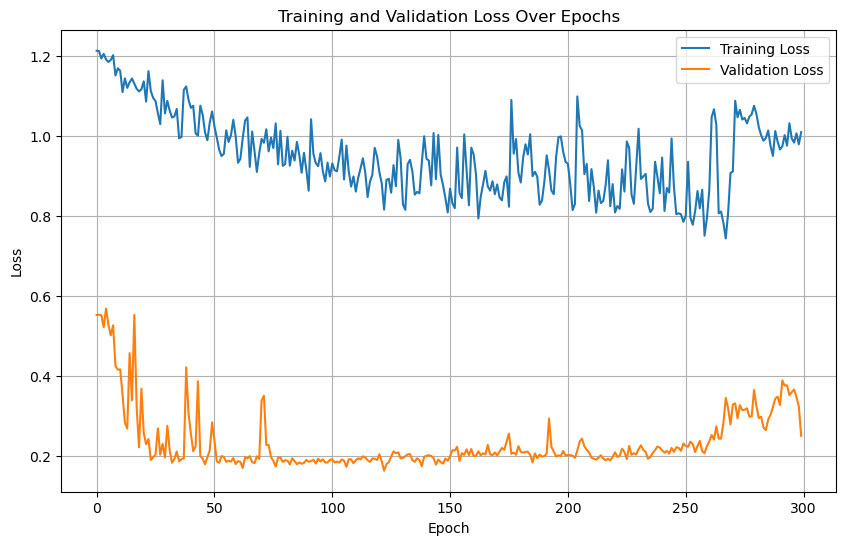

In [16]:
def plot_loss(train_losses, validation_losses):
    """
    Plots the training and validation losses over epochs.

    Args:
        train_losses (list): List of training loss values for each epoch.
        validation_losses (list): List of validation loss values for each epoch.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(validation_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss(best_mlp_losses_train, best_mlp_losses_validation)

### 3.2. LSTM

In [17]:
import random

random.seed(1)
def cat_name_generator(gender: str): return random.choice({"macho": ["Thor", "Loki", "Zeus", "Hades", "Apolo", "Ares", "Hermes", "Poseidon", "Hércules", "Aquiles", "Ulisses", "Atlas", "Perseu", "Orfeu", "Eros", "Hefesto", "Dionísio", "Héracles", "Cronos", "Prometeu", "Teseu", "Orfeu", "Eolo"], "femea": ["Afrodite", "Artemis", "Deméter", "Hera", "Perséfone", "Atena", "Héstia", "Eris", "Selene", "Gaia", "Tétis", "Eurídice", "Calipso", "Medusa", "Circe"]}[gender])

print("Nome de gato macho:", cat_name_generator("macho"))
print("Nome de gato fêmea:", cat_name_generator("femea"))

Nome de gato macho: Apolo
Nome de gato fêmea: Gaia


In [18]:
import torch.nn as nn
import torch.optim as optim
import numpy as np


# Define model with Linear layer
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout=LSTM_DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size, hidden_size, num_layers, batch_first=True, dropout=dropout
        )
        self.fc = nn.Linear(hidden_size, 1)  # Output a single value

    def forward(self, x, hidden_n=None, hidden_c=None):
        if hidden_n is None or hidden_c is None:
            out, _ = self.lstm(x)
            return self.fc(out[:, -1, :])  # Get output of last time step
        else:
            out, (hidden_n, hidden_c) = self.lstm(x, (hidden_n, hidden_c))
            out = self.fc(out[:, -1, :])  # Get output of last time step
            return out, (hidden_n, hidden_c)


def get_lstm_datasets(window_size=LSTM_WINDOW_SIZE):
    lstm_train_dataset_year_of_last = DatasetYearOfLast(
        NDVI[NDVI["Year"].isin(years_train)], PROD, window_size
    )
    lstm_validation_dataset_year_of_last = DatasetYearOfLast(
        NDVI[NDVI["Year"].isin(years_validation)], PROD, window_size
    )
    return (
        lstm_train_dataset_year_of_last,
        lstm_validation_dataset_year_of_last,
    )


def get_lstm_dataloaders(
    train_ds: DatasetYearOfLast,
    validation_ds: DatasetYearOfLast,
    batch_size=LSTM_BATCH_SIZE,
):
    lstm_train_loader_year_of_last = torch.utils.data.DataLoader(
        train_ds,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    lstm_validation_loader_year_of_last = torch.utils.data.DataLoader(
        validation_ds,
        batch_size=4,
        shuffle=False,
        drop_last=True,
    )
    return lstm_train_loader_year_of_last, lstm_validation_loader_year_of_last


def init_lstm_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if "weight_ih" in name:
                nn.init.xavier_uniform_(param.data)
            elif "weight_hh" in name:
                nn.init.orthogonal_(param.data)
            elif "bias" in name:
                nn.init.constant_(param.data, 0)


def init_lstm(
    hidden_size=LSTM_HIDDEN_SIZE, num_layers=LSTM_NUM_LAYERS, dropout=LSTM_DROPOUT
):
    lstm_model = LSTMRegressor(
        input_size=4, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout
    ).to(device)

    lstm_model.apply(init_lstm_weights)
    lstm_model.apply(init_linear_weights)
    return lstm_model


best_lstm_model = None
best_lstm_loss = float("inf")
best_lstm_losses_train = []
best_lstm_losses_validation = []


def train_lstm(
    epochs=LSTM_EPOCHS,
    hidden_size=LSTM_HIDDEN_SIZE,
    num_layers=LSTM_NUM_LAYERS,
    learning_rate=LSTM_LEARNING_RATE,
    dropout=LSTM_DROPOUT,
    batch_size=LSTM_BATCH_SIZE,
    window_size=LSTM_WINDOW_SIZE,
    verbose=False,
):
    best_model_found = False
    global best_lstm_model
    global best_lstm_loss
    global best_lstm_losses_train
    global best_lstm_losses_validation

    train_ds, validation_ds = get_lstm_datasets(window_size=window_size)

    lstm_train_loader, lstm_validation_loader = get_lstm_dataloaders(
        train_ds=train_ds, validation_ds=validation_ds, batch_size=batch_size
    )

    lstm_model = init_lstm(
        num_layers=num_layers,
        hidden_size=hidden_size,
        dropout=0.0 if num_layers == 1 else dropout,
    )

    optimizer = optim.Adam(lstm_model.parameters(), lr=learning_rate)
    loss_fn = nn.MSELoss()

    lstm_losses_train = []
    lstm_losses_validation = []
    best_loss = float("inf")
    saved_epoch = 0

    it = trange if verbose else range
    for i in it(epochs):
        epoch_losses_train = []

        # h_n = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
        #     device
        # )  # Hidden state
        # h_c = torch.zeros(LSTM_NUM_LAYERS, LSTM_BATCH_SIZE, LSTM_HIDDEN_SIZE).to(
        #     device
        # )  # Cell state

        lstm_model.train()
        for ndvi, prod in lstm_train_loader:
            ndvi, prod = ndvi.to(device), prod.to(device)
            optimizer.zero_grad()
            # pred, (h_n, h_c) = lstm_model(
            #     ndvi, h_n.detach(), h_c.detach()
            # )

            # Verificar se isto está certo
            # last_pred está correto?
            pred = lstm_model(ndvi)
            last_pred = pred[:, -1]
            loss = loss_fn(last_pred, prod)
            loss.backward()
            nn.utils.clip_grad_norm_(lstm_model.parameters(), 1.0)
            optimizer.step()
            epoch_losses_train.append(loss.item())

        epoch_losses_validation = []
        lstm_model.eval()
        with torch.no_grad():
            for ndvi, prod in lstm_validation_loader:
                ndvi, prod = ndvi.to(device), prod.to(device)
                pred = lstm_model(ndvi)
                last_pred = pred[:, -1]  # Get the last prediction
                loss = loss_fn(last_pred, prod)
                epoch_losses_validation.append(loss.item())

            if np.mean(epoch_losses_validation) < best_loss:
                best_loss = np.mean(epoch_losses_validation)
                saved_epoch = i + 1
                torch.save(lstm_model.state_dict(), "lstm.pth")

            if np.mean(epoch_losses_validation) < best_lstm_loss:
                best_model_found = True
                best_lstm_model = deepcopy(lstm_model)
                best_lstm_loss = np.mean(epoch_losses_validation)

        lstm_losses_train.append(np.mean(epoch_losses_train))
        lstm_losses_validation.append(np.mean(epoch_losses_validation))

    if best_model_found:
        best_lstm_losses_train = lstm_losses_train.copy()
        best_lstm_losses_validation = lstm_losses_validation.copy()

    verbose and print(
        f"\n\nSaved LSTM model\tepoch: {saved_epoch}\tvalidation loss: {best_loss:.4f}"
    )

    lstm_model.load_state_dict(torch.load("lstm.pth"))

    return best_loss


def get_best_loss(**kwargs):
    """
    Get the best loss from training
    """
    return -train_lstm(
        # epochs=int(kwargs["epochs"]),
        hidden_size=int(kwargs["hidden_size"]),
        num_layers=int(kwargs["num_layers"]),
        learning_rate=kwargs["learning_rate"],
        dropout=kwargs["dropout"],
        batch_size=int(kwargs["batch_size"]),
        window_size=int(kwargs["window_size"]),
    )


parameter_bounds = {
    "hidden_size": (16, 128.9999999999),  # 16 to 128
    "num_layers": (1, 2.9999999999),  # 1 or 2
    "learning_rate": (1e-6, 1e-3),
    "batch_size": (1, 16.9999999999),
    "dropout": (0.0, 0.3),
    # "epochs": (200, 1000.9999999999),  # (200, 1000.9999999999) 200 to 1000
    "window_size": (4, 20.9999999999),  # 4 to 20
}


acquisition_function = acquisition.UpperConfidenceBound(
    kappa=1.5,  # Start with slight exploration
    exploration_decay=0.76,  # Reduce kappa by 5% per step
    exploration_decay_delay=4,  # Only start decay after 2 steps
)

optimizer = BayesianOptimization(
    f=get_best_loss,
    pbounds=parameter_bounds,
    acquisition_function=acquisition_function,
    random_state=1,
)

optimizer.maximize(
    init_points=INIT_POINTS,
    n_iter=N_ITER,
)

|   iter    |  target   | batch_... |  dropout  | hidden... | learni... | num_la... | window... |
-------------------------------------------------------------------------------------------------
| 1         | -0.2388   | 7.672     | 0.2161    | 16.01     | 0.000303  | 1.294     | 5.57      |
| 2         | -0.3177   | 3.98      | 0.1037    | 60.83     | 0.0005393 | 1.838     | 15.65     |
| 3         | -0.2636   | 4.271     | 0.2634    | 19.09     | 0.0006708 | 1.835     | 13.5      |
| 4         | -0.2919   | 3.246     | 0.05943   | 106.5     | 0.0009683 | 1.627     | 15.77     |
| 5         | -0.5232   | 15.02     | 0.2684    | 25.61     | 4.002e-05 | 1.34      | 18.93     |
| 6         | -0.3167   | 2.574     | 0.1263    | 124.2     | 0.0005336 | 2.384     | 9.364     |
| 7         | -0.2337   | 11.98     | 0.2504    | 18.07     | 0.0007504 | 2.978     | 16.72     |
| 8         | -0.2419   | 5.487     | 0.2368    | 27.66     | 0.0004484 | 2.817     | 8.991     |
| 9         | -0.259

In [19]:
best_lstm_params = {**optimizer.max["params"]}
print(f"\n\nBest LSTM parameters:")
pprint(best_lstm_params)

best_lstm_model = best_lstm_model.to(device)



Best LSTM parameters:
{'batch_size': 8.503030645641935,
 'dropout': 0.13547321917032887,
 'hidden_size': 21.132707964981655,
 'learning_rate': 0.0005789152707078128,
 'num_layers': 2.690412942261257,
 'window_size': 6.377392979690054}


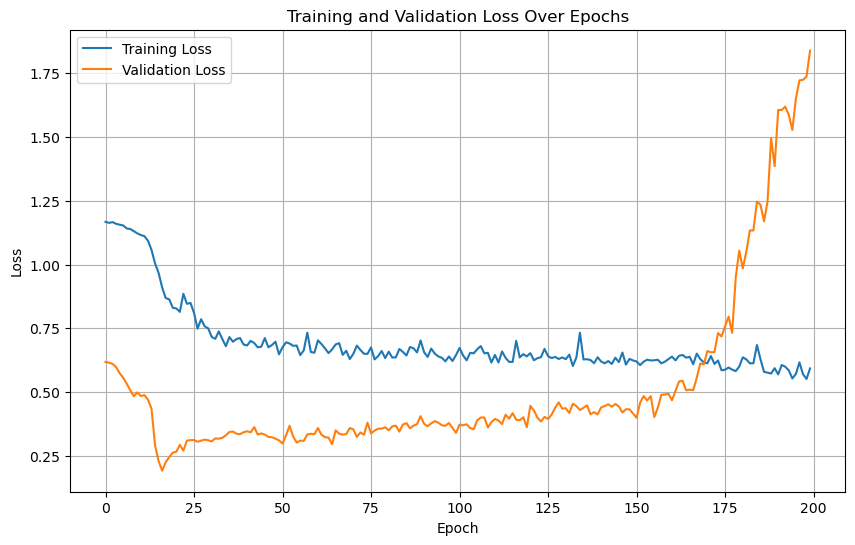

In [20]:
plot_loss(best_lstm_losses_train, best_lstm_losses_validation)

## 4. Avaliação do Modelo

In [21]:
mlp_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, int(best_mlp_params["window_size"])
)
lstm_test_dataset = DatasetYearOfLast(
    NDVI[NDVI["Year"].isin(years_test)], PROD, int(best_lstm_params["window_size"])
)

mlp_test_loader = torch.utils.data.DataLoader(
    mlp_test_dataset, batch_size=4, shuffle=False, drop_last=True
)
lstm_test_loader = torch.utils.data.DataLoader(
    lstm_test_dataset, batch_size=4, shuffle=False, drop_last=True
)

# test MLP
test_losses_mlp = []
best_mlp_model.eval()
loss_fn = nn.MSELoss()
for ndvi, prod in mlp_test_loader:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = best_mlp_model(ndvi)
    loss = loss_fn(pred, prod.unsqueeze(1))
    test_losses_mlp.append(loss.item())
print(f"MLP test loss: {np.mean(test_losses_mlp):.4f}")

# test LSTM
test_losses_lstm = []
best_lstm_model.eval()
for ndvi, prod in lstm_test_loader:
    ndvi, prod = ndvi.to(device), prod.to(device)
    pred = best_lstm_model(ndvi)
    last_pred = pred[:, -1]  # Get the last prediction
    loss = loss_fn(last_pred, prod)
    test_losses_lstm.append(loss.item())
    
print(f"LSTM test loss: {np.mean(test_losses_lstm):.4f}")

MLP test loss: 0.3213
LSTM test loss: 0.2704


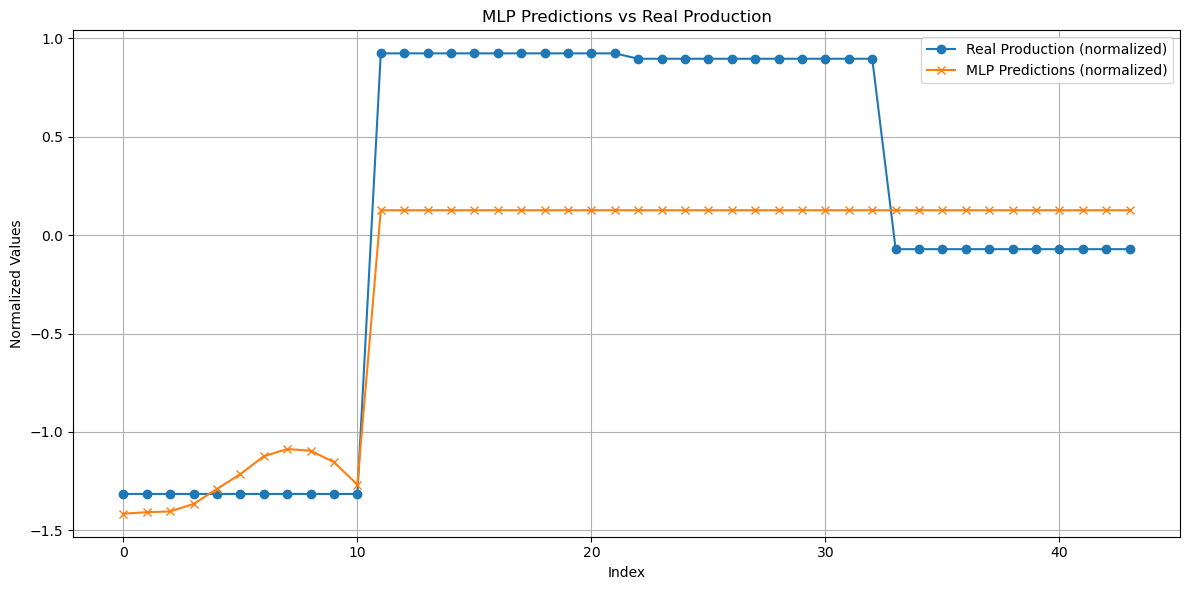

In [22]:
best_mlp_model.eval()
all_preds = []
real_prods = []

with torch.no_grad():
    for ndvi, prod in mlp_test_loader:
        ndvi, prod = ndvi.to(device), prod.to(device)
        pred = best_mlp_model(ndvi)
        all_preds.append(pred.cpu().numpy())
        real_prods.append(prod.cpu().numpy())

# Flatten the predictions and real productions
all_preds = np.concatenate(all_preds, axis=0).flatten()
real_prods = np.concatenate(real_prods, axis=0).flatten()

# Print predictions and real productions
# print("LSTM Predictions for all test dataset:")
# print(all_preds)
# print("\nReal Production (normalized) for all test dataset:")
# print(real_prods)

plt.figure(figsize=(12, 6))
plt.plot(real_prods, label="Real Production (normalized)", marker="o")
plt.plot(all_preds, label="MLP Predictions (normalized)", marker="x")
plt.xlabel("Index")
plt.ylabel("Normalized Values")
plt.title("MLP Predictions vs Real Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

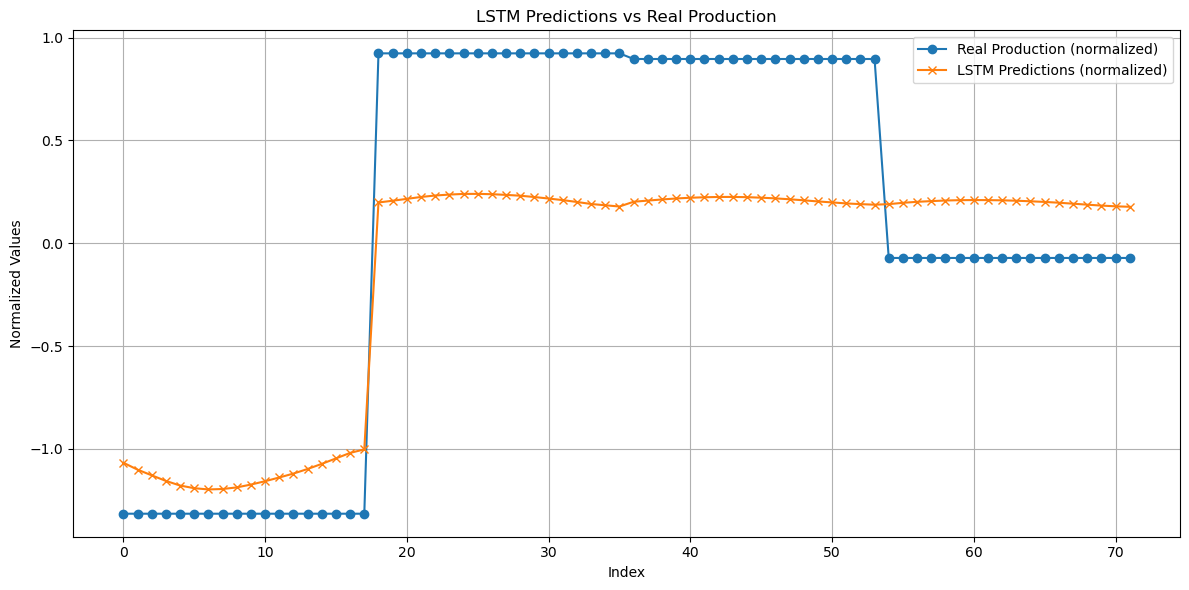

In [23]:
best_lstm_model.eval()
all_preds = []
real_prods = []

with torch.no_grad():
    for ndvi, prod in lstm_test_loader:
        ndvi, prod = ndvi.to(device), prod.to(device)
        pred = best_lstm_model(ndvi)
        all_preds.append(pred.cpu().numpy())
        real_prods.append(prod.cpu().numpy())

# Flatten the predictions and real productions
all_preds = np.concatenate(all_preds, axis=0)
real_prods = np.concatenate(real_prods, axis=0)

# Print predictions and real productions
# print("LSTM Predictions for all test dataset:")
# print(all_preds)
# print("\nReal Production (normalized) for all test dataset:")
# print(real_prods)

plt.figure(figsize=(12, 6))
plt.plot(real_prods, label="Real Production (normalized)", marker="o")
plt.plot(all_preds, label="LSTM Predictions (normalized)", marker="x")
plt.xlabel("Index")
plt.ylabel("Normalized Values")
plt.title("LSTM Predictions vs Real Production")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
print("MLP test loss:", np.mean(test_losses_mlp))
for y_test in years_test:
    ndvi, prod = mlp_test_dataset.get_last_window_of_year(y_test)
    ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(0).to(device)
    pred = best_mlp_model(ndvi)
    last_pred = pred[:, -1].cpu().detach().numpy()[0]
    test_losses_mlp.append(last_pred)
    print(f"\n[MLP] Predicted (normalized) productivity for {y_test}: {last_pred:.4f}")
    print(f"[MLP] Real productivity (normalized) for {y_test}: {prod:.4f}")

print("\n\nLSTM test loss:", np.mean(test_losses_lstm))
for y_test in years_test:
    ndvi, prod = lstm_test_dataset.get_last_window_of_year(y_test)
    ndvi = torch.tensor(ndvi, dtype=torch.float32).unsqueeze(0).to(device)
    pred = best_lstm_model(ndvi)
    last_pred = pred[:, -1].cpu().detach().numpy()[0]
    print(f"\n[LSTM] Predicted productivity (normalized) for {y_test}: {last_pred:.4f}")
    print(f"[LSTM] Real productivity (normalized) for {y_test}: {prod:.4f}")

MLP test loss: 0.3212865609252317

[MLP] Predicted (normalized) productivity for 2005: -1.2672
[MLP] Real productivity (normalized) for 2005: -1.3147

[MLP] Predicted (normalized) productivity for 2011: 0.1263
[MLP] Real productivity (normalized) for 2011: 0.9232

[MLP] Predicted (normalized) productivity for 2017: 0.1263
[MLP] Real productivity (normalized) for 2017: 0.8958

[MLP] Predicted (normalized) productivity for 2023: 0.1263
[MLP] Real productivity (normalized) for 2023: -0.0714


LSTM test loss: 0.2703579308775564

[LSTM] Predicted productivity (normalized) for 2005: -1.0020
[LSTM] Real productivity (normalized) for 2005: -1.3147

[LSTM] Predicted productivity (normalized) for 2011: 0.1786
[LSTM] Real productivity (normalized) for 2011: 0.9232

[LSTM] Predicted productivity (normalized) for 2017: 0.1875
[LSTM] Real productivity (normalized) for 2017: 0.8958

[LSTM] Predicted productivity (normalized) for 2023: 0.1774
[LSTM] Real productivity (normalized) for 2023: -0.0714
